<h3>Applications to Finance</h3>

<p>In this final chapter, we will use pandas to perform a number of different financial
analyses of stock data obtained from Yahoo! Finance. We will briefly cover a number of
topics in financial analysis. The focus will be on using pandas to derive results from the
domain of finance, specifically, time-series stock data, and not on details of the financial
theory.</p><p>Specifically, in this chapter, we will progress through the following tasks:</p>
    <ul>
    <li>Fetching and organizing stock data from Yahoo!</li>
<li>Plotting time-series prices</li>
<li>Plotting volume-series data</li>
<li>Calculating simple daily percentage change</li>
<li>Calculating simple daily cumulative returns</li>
<li>Resampling data from daily to monthly returns</li>
<li>Analyzing distribution of returns</li>
<li>Performing a moving-average calculation</li>
<li>Comparing average daily returns across stocks</li>
<li>Correlating stocks based on the daily percentage change of closing price</li>
<li>Volatility calculation</li>
<li>Determining risk relative to expected returns</li>
</ul>

In [1]:
# necessary imports for the workbook
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.testing import assert_frame_equal

# Set some pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 4)

# do all our graphics inline
%matplotlib inline

/Library/Python/3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


<h3>Obtaining and organizing stock data from
Yahoo!</h3>

<p>The first step we will take is to write a couple of functions that help us with retrieving
stock data from Yahoo! Finance. We have already seen that this data can be read using a
pandas DataReader object, but we will need to organize the data a little differently than
how it is provided by Yahoo! as we are going to perform various pivots of this information
later.</p><p>
To facilitate this, we will start with the following function to get all the Yahoo! data for a
specific stock between the two specified dates and also add the stock’s symbol in a column
for each entry. This will be needed later for pivots:</p>

In [2]:
# read data from Yahoo! Finance for a specific
# stock specified by ticker and between the start and end dates
def getStockData(ticker, start, end):
    # read the data
    data = web.DataReader(ticker, "yahoo", start, end)
    # rename this column
    data.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)
    # insert in the ticker as a column
    data.insert(0, "Ticker", ticker)
    return data

For consistency and reproducibility by the reader, examples in this chapter will use a fixed
3-year window spanning the years of 2012 through 2014. The following reads data for that
3-year period for the MSFT ticker and prints the first 5 rows:

In [3]:
# request the three years of data for MSFT
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2014, 12, 31)
getStockData("MSFT", start, end).head()

           Ticker   High    Low  ...  Close      Volume  AdjClose
Date                             ...                             
2012-01-03   MSFT  26.96  26.39  ...  26.77  6.4732e+07   21.9596
2012-01-04   MSFT  27.47  26.78  ...  27.40  8.0516e+07   22.4764
2012-01-05   MSFT  27.73  27.29  ...  27.68  5.6081e+07   22.7061
2012-01-06   MSFT  28.19  27.53  ...  28.11  9.9456e+07   23.0588
2012-01-09   MSFT  28.10  27.72  ...  27.74  5.9707e+07   22.7553

[5 rows x 7 columns]

Now that we have a function that can get data for a single ticker, it will be convenient to
have a function that can read the data for multiple tickers and return them all in a single
data structure. The following code performs this task:

In [4]:
# gets data for multiple stocks
# tickers: a list of stock symbols to fetch
# start and end are the start and end dates
def getDataForMultipleStocks(tickers, start, end):
    # we return a dictionary
    stocks = dict()
    # loop through all the tickers
    for ticker in tickers:
        # get the data for the specific ticker
        s = getStockData(ticker, start, end)
        # add it to the dictionary
        stocks[ticker] = s
        # return the dictionary
    return stocks

<p>The examples in this chapter will use historical quotes for Apple (AAPL), Microsoft
(MSFT), General Electric (GE), IBM (IBM), American Airlines (AA), Delta Airlines
(DAL), United Airlines (UAL), Pepsi (PEP), and Coca Cola (KO).</p><p>
These stocks were chosen deliberately to have a sample of multiple stocks in each of three
different sectors: technology, airlines, and soft drinks. The purpose of this is to
demonstrate how to derive correlations in various stock price measurements over the
selected time period among the stocks in similar sectors and to also demonstrate the
difference in stocks between sectors.</p><p>
We can read all of these with the following code, which uses the function we just created:</p>

In [5]:
# get the data for all the stocks that we want
raw = getDataForMultipleStocks(["MSFT", "AAPL", "GE", "IBM", "AA", "DAL",
"UAL", "PEP", "KO"], start, end)

In [6]:
# take a peek at the data for MSFT
raw['MSFT'][:5]

           Ticker   High    Low  ...  Close      Volume  AdjClose
Date                             ...                             
2012-01-03   MSFT  26.96  26.39  ...  26.77  6.4732e+07   21.9596
2012-01-04   MSFT  27.47  26.78  ...  27.40  8.0516e+07   22.4764
2012-01-05   MSFT  27.73  27.29  ...  27.68  5.6081e+07   22.7061
2012-01-06   MSFT  28.19  27.53  ...  28.11  9.9456e+07   23.0588
2012-01-09   MSFT  28.10  27.72  ...  27.74  5.9707e+07   22.7553

[5 rows x 7 columns]

We will be particularly interested in the adjusted close values in the AdjClose column.
However, it would be most convenient for us if we had a DataFrame object indexed by
date but where each column is the stock ticker for one stock and the values in each column
are the adjusted close value for that ticker at that date. We can have this format if we pivot
the data around. The following function will do this for us:

In [7]:
# given the dictionary of data frames,
# pivots a given column into values with column
# names being the stock symbols
def pivotTickersToColumns(raw, column):
    items = []
    # loop through all dictionary keys
    for key in raw:
        # get the data for the key
        data = raw[key]
        # extract just the column specified
        subset = data[["Ticker", column]]
        # add to items
        items.append(subset)
        
    # concatenate all the items
    combined = pd.concat(items)

    # reset the index
    ri = combined.reset_index()
    # return the pivot
    
    return ri.pivot("Date", "Ticker", column)

In [8]:
# do the pivot
close_px = pivotTickersToColumns(raw, "AdjClose")

# peek at the result
close_px[:5]

Ticker           AA     AAPL     DAL  ...     MSFT      PEP    UAL
Date                                  ...                         
2012-01-03  20.8934  50.7657  7.1419  ...  21.9596  51.7651  18.90
2012-01-04  21.3914  51.0385  7.1153  ...  22.4764  52.0301  18.52
2012-01-05  21.1877  51.6052  7.3995  ...  22.7061  51.6248  18.39
2012-01-06  20.7350  52.1446  7.3907  ...  23.0588  50.9777  18.21
2012-01-09  21.3462  52.0619  7.3551  ...  22.7553  51.2428  17.93

[5 rows x 9 columns]

We now have the adjusted close values for all stocks as values in a column for each
respective stock. In this format, we will be able to very easily compare closing price
values of each stock against the others.

<h4>Plotting time-series prices</h4>

We will perform a graphical comparison of the closing values for AAPL and MSFT. Using
the closing prices DataFrame, it is simple to plot the values for a specific stock using the
.plot() method of Series. The following plots the adjusted closing price for AAPL:

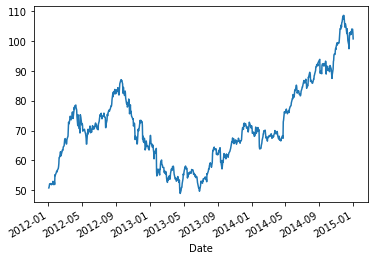

In [9]:
# plot the closing prices of AAPL
close_px['AAPL'].plot();

The following code plots the adjusted closing price for MSFT:

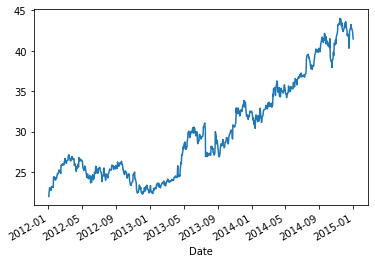

In [10]:
# plot the closing prices of MSFT
close_px['MSFT'].plot();

Both sets of closing values can easily be displayed on a single chart in order to give a sideby-
side comparison:

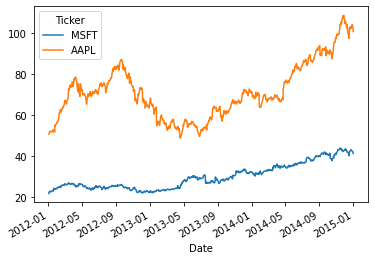

In [11]:
# plot MSFT vs AAPL on the same chart
close_px[['MSFT', 'AAPL']].plot();

<h3>Plotting volume-series data</h3>

Volume data can be plotted using bar charts. We first need to get the volume data, which
can be done using the pivotTickersToColumns() function created earlier:

In [12]:
# pivot the volume data into columns
volumes = pivotTickersToColumns(raw, "Volume")
volumes.tail()

Ticker             AA        AAPL        DAL  ...        MSFT        PEP  \
Date                                          ...                          
2014-12-24  2057400.0  1.4480e+07  4296200.0  ...  1.1438e+07  1604100.0   
2014-12-26  2644900.0  3.3721e+07  5303100.0  ...  1.3198e+07  1492700.0   
2014-12-29  2949500.0  2.7599e+07  6656700.0  ...  1.4440e+07  2453800.0   
2014-12-30  3854300.0  2.9882e+07  7318900.0  ...  1.6385e+07  2134400.0   
2014-12-31  3679600.0  4.1403e+07  7772200.0  ...  2.1552e+07  3727400.0   

Ticker            UAL  
Date                   
2014-12-24  2714300.0  
2014-12-26  3062200.0  
2014-12-29  2874300.0  
2014-12-30  2644600.0  
2014-12-31  4440500.0  

[5 rows x 9 columns]

We can now use this DataFrame to plot a bar chart. The following plots the volume for
MSFT:

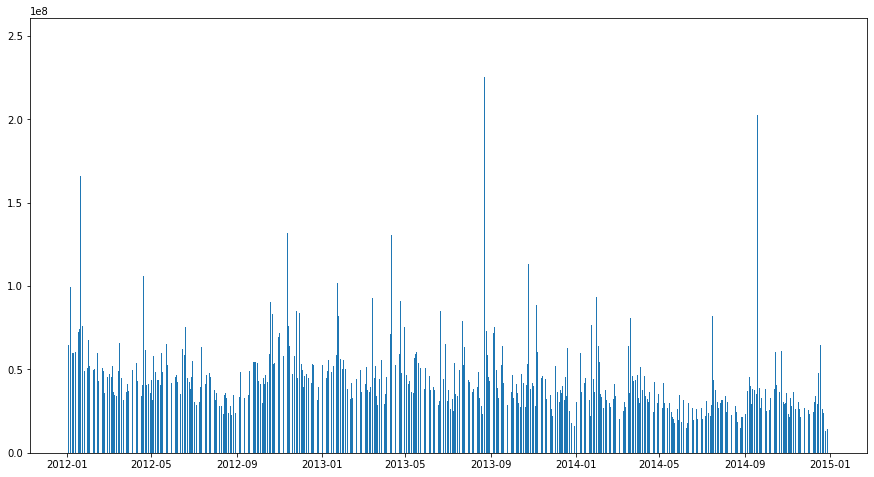

In [13]:
# plot the volume for MSFT
msftV = volumes[["MSFT"]]
plt.bar(msftV.index, msftV["MSFT"])
plt.gcf().set_size_inches(15,8)

A common type of financial graph plots a stock volume relative to its closing price:

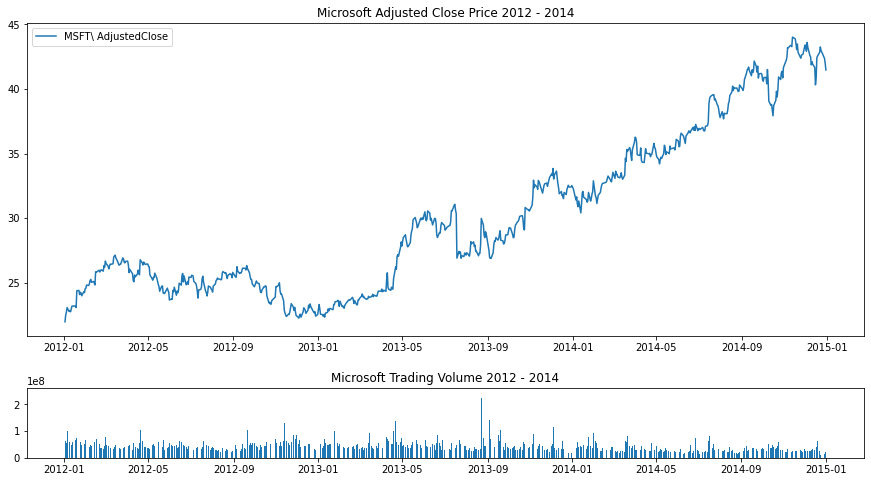

In [14]:
# draw the price history on the top
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(close_px['MSFT'].index, close_px['MSFT'], label='MSFT\ AdjustedClose')
plt.title('Microsoft Adjusted Close Price 2012 - 2014')
plt.legend(loc=2)
         
# and the volume along the bottom
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(msftV.index, msftV['MSFT'])
plt.title('Microsoft Trading Volume 2012 - 2014')
plt.subplots_adjust(hspace=0.75)
plt.gcf().set_size_inches(15,8)

<h3>Calculating the simple daily percentage change</h3>

The simple daily percentage change (without dividends and other factors) is the
percentage change in value of a stock over a single day of trading. It is defined by the
following formula:
<img src="data/prc_change_formula.png">

This can be easily calculated in pandas using .shift():

In [15]:
# calculate daily percentage change
daily_pc = close_px / close_px.shift(1) - 1
daily_pc[:5]

Ticker          AA    AAPL     DAL  ...    MSFT     PEP     UAL
Date                                ...                        
2012-01-03     NaN     NaN     NaN  ...     NaN     NaN     NaN
2012-01-04  0.0238  0.0054 -0.0037  ...  0.0235  0.0051 -0.0201
2012-01-05 -0.0095  0.0111  0.0399  ...  0.0102 -0.0078 -0.0070
2012-01-06 -0.0214  0.0105 -0.0012  ...  0.0155 -0.0125 -0.0098
2012-01-09  0.0295 -0.0016 -0.0048  ... -0.0132  0.0052 -0.0154

[5 rows x 9 columns]

In [16]:
close_px[:5]

Ticker           AA     AAPL     DAL  ...     MSFT      PEP    UAL
Date                                  ...                         
2012-01-03  20.8934  50.7657  7.1419  ...  21.9596  51.7651  18.90
2012-01-04  21.3914  51.0385  7.1153  ...  22.4764  52.0301  18.52
2012-01-05  21.1877  51.6052  7.3995  ...  22.7061  51.6248  18.39
2012-01-06  20.7350  52.1446  7.3907  ...  23.0588  50.9777  18.21
2012-01-09  21.3462  52.0619  7.3551  ...  22.7553  51.2428  17.93

[5 rows x 9 columns]

In [17]:
close_px.shift(1)[:5]

Ticker           AA     AAPL     DAL  ...     MSFT      PEP    UAL
Date                                  ...                         
2012-01-03      NaN      NaN     NaN  ...      NaN      NaN    NaN
2012-01-04  20.8934  50.7657  7.1419  ...  21.9596  51.7651  18.90
2012-01-05  21.3914  51.0385  7.1153  ...  22.4764  52.0301  18.52
2012-01-06  21.1877  51.6052  7.3995  ...  22.7061  51.6248  18.39
2012-01-09  20.7350  52.1446  7.3907  ...  23.0588  50.9777  18.21

[5 rows x 9 columns]

A quick check shows you that the return for AAPL on 2011-09-08 is correct:

In [18]:
# check the percentage on 2012-01-05
close_px.loc['2012-01-05']['AA'] / close_px.loc['2012-01-04']['AA'] -1

-0.009523802730349362

Plotting the daily percentage change yields the following plot:

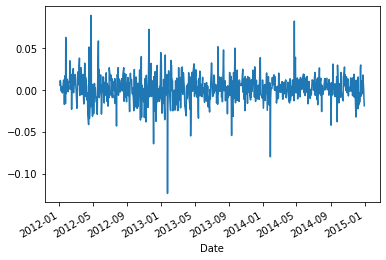

In [19]:
# plot daily percentage change for AAPL
daily_pc["AAPL"].plot();

A plot of daily percentage change will tend to look like noise, as shown in the preceding
chart. However, when we use the cumulative product of these values, known as the daily
cumulative return, then we can see how the value changes over time.

<h3>Calculating simple daily cumulative returns</h3>

We can calculate the cumulative daily return by taking the cumulative product of the daily
percentage change. This calculation is represented by the following equation:

<img src="data/daily_commulative_returns.png">

This is actually calculated very succinctly using the following code, which utilizes the
.cumprod() method:

In [20]:
# calculate daily cumulative return
daily_cr = (1 + daily_pc).cumprod()
daily_cr[:5]

Ticker          AA    AAPL     DAL  ...    MSFT     PEP     UAL
Date                                ...                        
2012-01-03     NaN     NaN     NaN  ...     NaN     NaN     NaN
2012-01-04  1.0238  1.0054  0.9963  ...  1.0235  1.0051  0.9799
2012-01-05  1.0141  1.0165  1.0361  ...  1.0340  0.9973  0.9730
2012-01-06  0.9924  1.0272  1.0348  ...  1.0501  0.9848  0.9635
2012-01-09  1.0217  1.0255  1.0299  ...  1.0362  0.9899  0.9487

[5 rows x 9 columns]

In [21]:
daily_cr[:-5]

Ticker          AA    AAPL     DAL  ...    MSFT     PEP     UAL
Date                                ...                        
2012-01-03     NaN     NaN     NaN  ...     NaN     NaN     NaN
2012-01-04  1.0238  1.0054  0.9963  ...  1.0235  1.0051  0.9799
2012-01-05  1.0141  1.0165  1.0361  ...  1.0340  0.9973  0.9730
2012-01-06  0.9924  1.0272  1.0348  ...  1.0501  0.9848  0.9635
2012-01-09  1.0217  1.0255  1.0299  ...  1.0362  0.9899  0.9487
...            ...     ...     ...  ...     ...     ...     ...
2014-12-17  1.6893  1.9667  5.8192  ...  1.8597  1.5402  3.3254
2014-12-18  1.7713  2.0249  5.8948  ...  1.9321  1.5672  3.3995
2014-12-19  1.7892  2.0093  5.9717  ...  1.9377  1.5685  3.3937
2014-12-22  1.7668  2.0301  5.9755  ...  1.9508  1.5879  3.3862
2014-12-23  1.7656  2.0229  5.9402  ...  1.9699  1.6000  3.3058

[749 rows x 9 columns]

We can plot the cumulative returns to see how the different stocks compare:

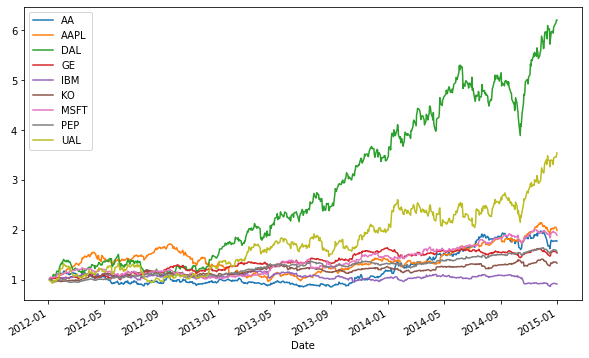

In [22]:
# plot all the cumulative returns to get an idea
# of the relative performance of all the stocks
daily_cr.plot(figsize=(10,6))
plt.legend(loc=2);

<h3>Resampling data from daily to monthly returns</h3>

To calculate the monthly rate of return, we can use a little pandas magic and resample the
original daily dates to throw out the days that are not an end of month value as well as
forward filling anywhere there are missing values. This can be done using the ffill
method to replace any NaN values from missing data with the previous value:

In [23]:
# resample to end of month and forward fill values
monthly = close_px.asfreq('BM', method="ffill")
monthly[:5]

Ticker           AA     AAPL      DAL  ...     MSFT      PEP    UAL
Date                                   ...                         
2012-01-31  22.9986  56.3518   9.3716  ...  24.2237  51.1960  23.10
2012-02-29  23.0894  66.9634   8.7142  ...  26.2080  49.4700  20.65
2012-03-30  22.7489  74.0135   8.8119  ...  26.6373  52.1503  21.50
2012-04-30  22.0905  72.0914   9.7358  ...  26.4392  51.8752  21.92
2012-05-31  19.4753  71.3199  10.7484  ...  24.2606  53.7463  25.17

[5 rows x 9 columns]

<p>Note the date of the entries and how they are now only month-end dates. Values have not
changed as the resample only selects the dates at the end of the month or fills the value
with the value prior to that date if it did not exist in the source.</p><p>
Now we can use this to calculate the monthly percentage changes:</p>

In [24]:
# calculate the monthly percentage changes
monthly_pc = monthly / monthly.shift(1) - 1
monthly_pc[:5]

Ticker          AA    AAPL     DAL  ...    MSFT     PEP     UAL
Date                                ...                        
2012-01-31     NaN     NaN     NaN  ...     NaN     NaN     NaN
2012-02-29  0.0039  0.1883 -0.0701  ...  0.0819 -0.0337 -0.1061
2012-03-30 -0.0147  0.1053  0.0112  ...  0.0164  0.0542  0.0412
2012-04-30 -0.0289 -0.0260  0.1048  ... -0.0074 -0.0053  0.0195
2012-05-31 -0.1184 -0.0107  0.1040  ... -0.0824  0.0361  0.1483

[5 rows x 9 columns]

From that result, calculate the monthly cumulative returns and plot the results:

In [25]:
# calculate monthly cumulative return
monthly_cr = (1 + monthly_pc).cumprod()
monthly_cr[:5]

Ticker          AA    AAPL     DAL  ...    MSFT     PEP     UAL
Date                                ...                        
2012-01-31     NaN     NaN     NaN  ...     NaN     NaN     NaN
2012-02-29  1.0039  1.1883  0.9299  ...  1.0819  0.9663  0.8939
2012-03-30  0.9891  1.3134  0.9403  ...  1.0996  1.0186  0.9307
2012-04-30  0.9605  1.2793  1.0389  ...  1.0915  1.0133  0.9489
2012-05-31  0.8468  1.2656  1.1469  ...  1.0015  1.0498  1.0896

[5 rows x 9 columns]

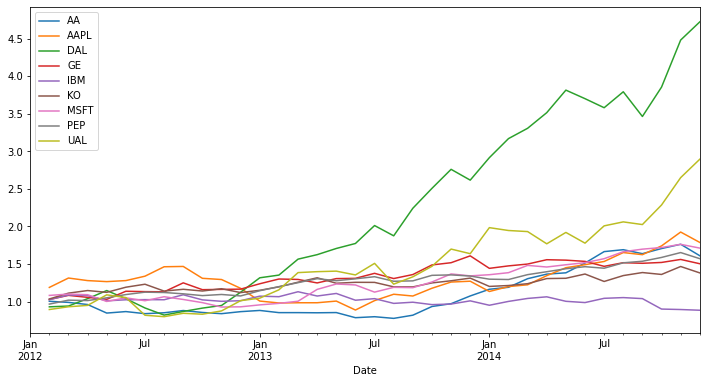

In [26]:
# plot the monthly cumulative returns
monthly_cr.plot(figsize=(12,6))
plt.legend(loc=2);

This looks very similar to the daily returns, but overall, it is not as smooth. This is because
it uses roughly a 30th of the data and is tied to the end of month.

<h3>Analyzing distribution of returns</h3>

<p>You can get a feel for the difference in distribution of the daily percentage changes for a
particular stock by plotting that data in a histogram. A trick with generating histograms for
data such as daily returns is to select the number of bins to lump values into. We will use
50 bins, which gives you a good feel for the distribution of daily changes across three
years of data.</p><p>
To demonstrate, the following shows you the distribution of the daily percentage change
for AAPL:</p>

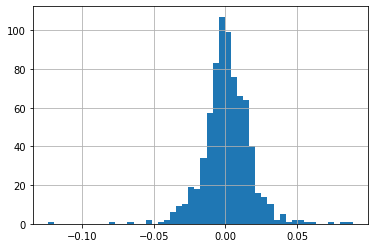

In [31]:
# histogram of the daily percentage change for AAPL
aapl = daily_pc['AAPL']
aapl.hist(bins=50);

This chart tells us several things. First, most of the daily movements center around 0.0,
and there is a small amount of skew to the left, but the data appears fairly symmetric. If
we use the .describe() method on this data, we will very quickly get some useful
analysis to describe the histogram:

In [32]:
# descriptive statistics of the percentage changes
aapl.describe()

count    753.0000
mean       0.0011
std        0.0169
min       -0.1236
25%       -0.0074
50%        0.0005
75%        0.0110
max        0.0887
Name: AAPL, dtype: float64

<p>A valuable conclusion to be drawn from this is the 95 percent coverage interval, which
varies from -0.007476 to 0.010893. This states that over this 3-year period, the daily
percent of change fit between these two percentages 95 percent of the time. This gives us a
sense of the overall volatility in the stock. Technically, the closer these values, the less
volatile the stock over that time.</p><p>
We can plot the histograms of the daily percentage change for all the stocks in a single
histogram matrix plot. This gives us a means to quickly determine the differences in stock
behavior over these 3 years:</p>

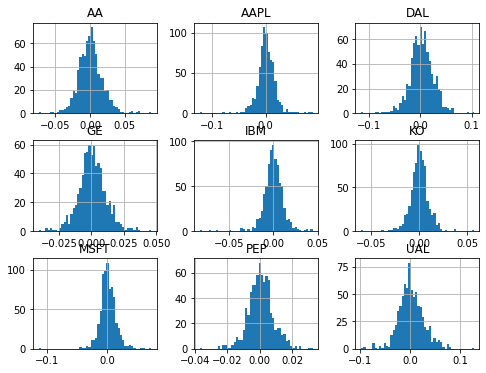

In [33]:
# matrix of all stocks daily percentage changes histograms
daily_pc.hist(bins=50, figsize=(8,6));

<p>The labels on the axis are a bit squished together, but it’s the histogram shape that is the
most important.</p><p>
From this chart, we can very easily see the difference in performance of these nine stocks
during this time, particularly, the skewedness (more exceptional values on one side of the
mean) as well as easily being able to easily see the difference in the overall distribution at
various confidence levels, thereby giving a quick view of which stocks have been more or
less volatile.</p><p>
This is an excellent demonstration of the value of a picture versus using raw data items.
Exploratory analysis like this is made very simple by the pandas ecosystem and allows
you to more agilely analyze information.</p>

<h3>Performing a moving-average calculation</h3>

<p>The moving average of a stock can be calculated using the pandas statistical package that
is a part of pandas and is in the pd.stats namespace, specifically, the .rolling().mean()
method.</p><p>
The moving average will give you a sense of the performance of a stock over a given time
period by eliminating “noise” in the performance of the stock. The larger the moving
window, the smoother and less random the graph will be—at the expense of accuracy.</p><p>
To demonstrate, the following calculates the moving average for MSFT on 30 and 90 day
periods using the daily close. The difference in the reduction of noise can be easily
determined from the visual:</p>

In [39]:
# extract just MSFT close
msft_close = close_px[['MSFT']]['MSFT']
msft_close

Date
2012-01-03    21.9596
2012-01-04    22.4764
2012-01-05    22.7061
2012-01-06    23.0588
2012-01-09    22.7553
               ...   
2014-12-24    42.9807
2014-12-26    42.7485
2014-12-29    42.3646
2014-12-30    41.9807
2014-12-31    41.4718
Name: MSFT, Length: 754, dtype: float64

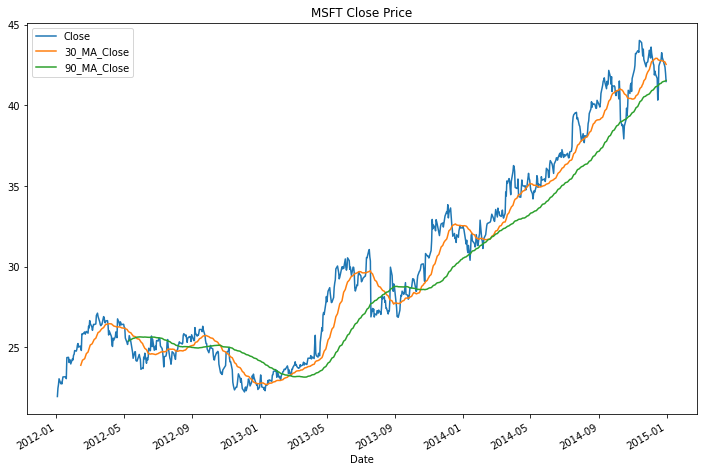

In [40]:
# calculate the 30 and 90 day rolling means
ma_30 = msft_close.rolling(30).mean()
ma_90 = msft_close.rolling(90).mean()

# compose into a DataFrame that can be plotted
result = pd.DataFrame({'Close': msft_close, '30_MA_Close': ma_30, '90_MA_Close': ma_90})

# plot all the series against each other
result.plot(title="MSFT Close Price")
plt.gcf().set_size_inches(12,8)

<h3>The comparison of average daily returns across
stocks</h3>